In [1]:
# | code-summary: code -- load dependencies and data and select parameters


from compmemlearn.fitting import generate_objective_function, apply_and_concatenate
from compmemlearn.datasets import simulate_df
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

section_introduction = """
## Simulation of Penn Electrophysiology of Encoding and Retrieval Study (PEERS)
We start by comparing how our prototype- and instance-based implementations of CMR account for behavior in a classic experiment where each item is presented just once per study phase. For these simulations, we used the PEERS dataset reported by . Each of 72 undergraduates performed 20 trials with study lists each consisting of 20 unique words visually presented at either 60 or 120 words per minute. Given a particular subject, words were unique both within and across trials, and randomly selected from the Toronto Word Pool [@friendly1982toronto], a widely-used collection of high frequency nouns, adjectives, and verbs.

While the major focus of the original report by @murdock1970interresponse was to investigate inter-response times in single-trial free recall, here we focus consideration on the content of recorded recall sequences. Because it excludes within-list repetitions of studied items, this dataset presents the opportunity to compare model performance under simplified conditions. Since items' feature representations are assumed orthogonal under considered variants of CMR, retrieving a pattern of contextual associations given an item-based cue only requires abstraction over the cued item's pre-experimental and single experimental contextual associations. Interpretation of apparent differences in performance across model variants thus focus primarily on mechanisms for context-based item representation retrieval.

We compared the original prototype-based implementation of CMR against our novel instance-based implementation. First we evaluated each model variant based on their ability to predict the specific sequences of recalls exhibited by each participant. Considering all trials performed by each participant in the dataset, we applied the differential evolution optimization technique to find for each model the parameter configuration that maximized the likelihood of recorded recall sequences. We obtained a unique optimal parameter configuration for each unique participant and each considered model variant. To measure the goodness-of-fit for each parameter configuration and corresponding model, [Figure @fig-{section_tag}Fits] plots the log-likelihood of each participant's recall sequences given each model variant's corresponding optimized parameter configuration.
"""

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in PEERS dataset under each considered model."""

section_tag = "PEERS"

data_path = "../data/PEERS.csv"
data_query = "task == -1 & session != 0"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR"]

free_parameters = [
    [
        'encoding_drift_rate',
        'start_drift_rate',
        'recall_drift_rate',
        'shared_support',
        'item_support',
        'learning_rate',
        'primacy_scale',
        'primacy_decay',
        'stop_probability_scale',
        'stop_probability_growth',
        'choice_sensitivity',
        'delay_drift_rate'
    ],
        [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        'choice_sensitivity',
        #    "context_sensitivity",
        #    "feature_sensitivity",
        "delay_drift_rate",
    ]
]

bounds = [
    [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
    ],
        [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"context_sensitivity": 1, "feature_sensitivity": 1},
]


In [2]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

# load dataset and extract key metadata
events = pd.read_csv(data_path).query(data_query)


In [ ]:

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    cost_function = generate_objective_function(
        events,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        cost_function(x)

In [3]:
#| echo: false
#| input: false
#| output: asis

print(section_introduction.format(section_tag=section_tag))


## Simulation of Penn Electrophysiology of Encoding and Retrieval Study (PEERS)
We start by comparing how our prototype- and instance-based implementations of CMR account for behavior in a classic experiment where each item is presented just once per study phase. For these simulations, we used the PEERS dataset reported by . Each of 72 undergraduates performed 20 trials with study lists each consisting of 20 unique words visually presented at either 60 or 120 words per minute. Given a particular subject, words were unique both within and across trials, and randomly selected from the Toronto Word Pool [@friendly1982toronto], a widely-used collection of high frequency nouns, adjectives, and verbs.

While the major focus of the original report by @murdock1970interresponse was to investigate inter-response times in single-trial free recall, here we focus consideration on the content of recorded recall sequences. Because it excludes within-list repetitions of studied items, this dataset pr

In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

individual_fits = []
labels = []

for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    for subject in pd.unique(events.subject):
        print(f'{model_names[model_index]}, Subject {subject}')
        subset = events.query(f'subject == {subject}')

        # cost function to be minimized
        # ours scales inversely with the probability that the data could have been
        # generated using the specified parameters and our model
        cost_function = generate_objective_function(
            subset,
            init_model,
            fixed_parameters[model_index],
            free_parameters[model_index],
        )

        individual_fits.append(
            differential_evolution(
                cost_function, bounds[model_index], disp=False
            ).fun
        )
        labels.append(model_names[model_index])
        print(individual_fits[-1])

PrototypeCMR, Subject 0
1055.4131504370284
PrototypeCMR, Subject 1
801.4110522745943
PrototypeCMR, Subject 2
879.1343485095902
PrototypeCMR, Subject 3
864.0094383018103
PrototypeCMR, Subject 4
974.128128023466
PrototypeCMR, Subject 5
251.81479035581694
PrototypeCMR, Subject 6
1034.0356466447267
PrototypeCMR, Subject 7
818.2144353294495
PrototypeCMR, Subject 8
1051.177810602635
PrototypeCMR, Subject 9
944.8009267421676
PrototypeCMR, Subject 10
312.1524386610909
PrototypeCMR, Subject 11
748.7218014418268
PrototypeCMR, Subject 12
1006.753464266763
PrototypeCMR, Subject 13
681.745477359569
PrototypeCMR, Subject 14
181.92257883907786
PrototypeCMR, Subject 15
1008.5591068024121
PrototypeCMR, Subject 16
1005.731527839846
PrototypeCMR, Subject 17
541.8952972982593
PrototypeCMR, Subject 18
665.193286021907
PrototypeCMR, Subject 19
1104.3844714793834
PrototypeCMR, Subject 20
667.5291764708933
PrototypeCMR, Subject 21
992.067484296366
PrototypeCMR, Subject 22
479.47277930916255
PrototypeCMR, Subj

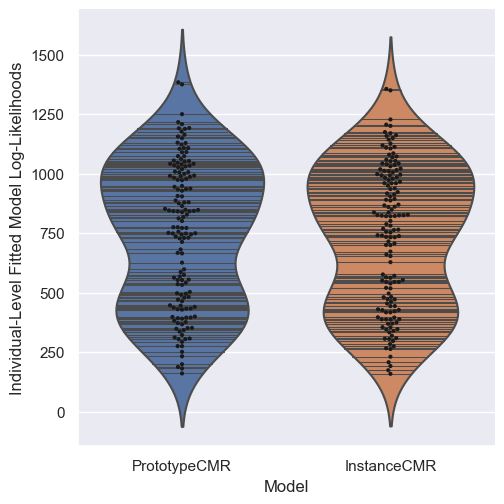

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')

individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']
individual_df.to_csv('individual_{}.csv'.format(section_tag))

sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
plt.savefig('individual_{}.pdf'.format(section_tag), bbox_inches="tight")



In [6]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

individual_df = pd.read_csv('individual_{}.csv'.format(section_tag))
individual_df.drop(columns=['Unnamed: 0'], inplace=True)
individual_df

,Model,Fit
0,PrototypeCMR,1055.413150
1,PrototypeCMR,801.411052
2,PrototypeCMR,879.134349
3,PrototypeCMR,864.009438
4,PrototypeCMR,974.128128
...,...,...
293,InstanceCMR,396.022345
294,InstanceCMR,471.921110
295,InstanceCMR,417.640904
296,InstanceCMR,369.551846


In [8]:
summary_table = pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown()

summary_table

'|       |   InstanceCMR |   PrototypeCMR |\n|:------|--------------:|---------------:|\n| count |       149     |        149     |\n| mean  |       735.661 |        746.176 |\n| std   |       297.578 |        302.695 |\n| min   |       159.329 |        161.113 |\n| 25%   |       454.996 |        464.551 |\n| 50%   |       768.767 |        775.162 |\n| 75%   |       993.103 |       1005.73  |\n| max   |      1356.17  |       1383.96  |'

In [9]:
print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![](individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption))

::: {#fig-PEERSfits layout-nrow=2 layout-valign="center"}

![](individual_PEERS.pdf)

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |       149     |        149     |
| mean  |       735.661 |        746.176 |
| std   |       297.578 |        302.695 |
| min   |       159.329 |        161.113 |
| 25%   |       454.996 |        464.551 |
| 50%   |       768.767 |        775.162 |
| 75%   |       993.103 |       1005.73  |
| max   |      1356.17  |       1383.96  |

Distribution of log-likelihood scores of recall sequences exhibited by each subject in PEERS dataset under each considered model.
:::


In [10]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_ind
import itertools

individual_df = pd.read_csv('individual_{}.csv'.format(section_tag))
for combination in itertools.combinations(pd.unique(individual_df.Model), 2):

    print(combination)
    print(ttest_ind(individual_df[individual_df.Model == combination[0]].Fit, individual_df[individual_df.Model == combination[1]].Fit))
    print()

('PrototypeCMR', 'InstanceCMR')
Ttest_indResult(statistic=0.3023685045481785, pvalue=0.7625835195832362)

